In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F

In [40]:
def load_dakshina_lexicon_pairs(filepath):
    pairs=[]
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            parts = line.split('\t')
            if len(parts) != 3:
                continue  # skip malformed lines
            devanagari_word, latin_word,_ = parts
            pairs.append((latin_word, devanagari_word))  # reverse order
    return pairs

In [41]:
def build_vocab(pairs, add_special_tokens=True):
    input_chars = set() # to ensure no repeated characters
    output_chars = set()

    # Collect unique characters from Latin (input) and Devanagari (output)
    for latin_word, devnagari_word in pairs:
        input_chars.update(list(latin_word))
        output_chars.update(list(devnagari_word))

    # Sort to keep it consistent
    input_chars = sorted(list(input_chars))
    output_chars = sorted(list(output_chars))

    # Add special tokens
    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>'] if add_special_tokens else []

    input_vocab = special_tokens + input_chars
    output_vocab = special_tokens + output_chars

    # Create dictionaries
    input_char2idx = {ch: idx for idx, ch in enumerate(input_vocab)}
    input_idx2char = {idx: ch for ch, idx in input_char2idx.items()}

    output_char2idx = {ch: idx for idx, ch in enumerate(output_vocab)}
    output_idx2char = {idx: ch for ch, idx in output_char2idx.items()}

    return input_char2idx, input_idx2char, output_char2idx, output_idx2char

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size, num_encoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_encoder_layers = num_encoder_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        else:  # default to RNN
            self.rnn = nn.RNN(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
    
    def forward(self, input_seq, lengths):
        """
        Forward pass for encoder
        
        Args:
            input_seq: Input sequence tensor [batch_size, max_seq_len]
            lengths: Actual lengths of input sequences (tensor)
            
        Returns:
            None: Instead of encoder outputs (to avoid DataParallel issues)
            hidden: Hidden state for decoder initialization
        """
        batch_size = input_seq.size(0)
        
        # Important: ensure lengths is on CPU before using it
        if lengths.is_cuda:
            lengths = lengths.cpu()
        
        # Convert input to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )
        
        # Process with RNN
        if self.cell_type == 'lstm':
            # Don't return outputs to avoid DataParallel gathering issues
            outputs, (hidden, cell) = self.rnn(packed)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.rnn(packed)
            return outputs, hidden


In [43]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_size, hidden_size, num_decoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_decoder_layers = num_decoder_layers
        self.output_vocab_size = output_vocab_size
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(output_vocab_size, embed_size)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embed_size, hidden_size, num_decoder_layers,
                batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embed_size, hidden_size, num_decoder_layers,
                batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0
            )
        else:  # default to RNN
            self.rnn = nn.RNN(
                embed_size, hidden_size, num_decoder_layers,
                batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0
            )
        
        # Output layer
        self.out = nn.Linear(hidden_size, output_vocab_size)
    
    def _convert_encoder_hidden(self, encoder_hidden):
        """
        Convert encoder hidden state to fit decoder dimensions
        
        Args:
            encoder_hidden: Encoder's hidden state
                           For RNN/GRU: tensor of shape (num_encoder_layers, batch_size, hidden_size)
                           For LSTM: tuple of two tensors with that shape
        
        Returns:
            Hidden state with shape compatible with decoder
        """
        if self.cell_type == 'lstm':
            # For LSTM, encoder_hidden is a tuple (hidden, cell)
            hidden, cell = encoder_hidden
            
            # Get shapes
            num_encoder_layers, batch_size, hidden_size = hidden.shape
            
            # Return as is if dimensions already match
            if num_encoder_layers == self.num_decoder_layers:
                return encoder_hidden
            
            # Initialize decoder hidden state
            decoder_hidden = torch.zeros(self.num_decoder_layers, batch_size, hidden_size, device=hidden.device)
            decoder_cell = torch.zeros(self.num_decoder_layers, batch_size, hidden_size, device=cell.device)
            
            # Fill decoder hidden state
            if num_encoder_layers >= self.num_decoder_layers:
                # Take the last layers from encoder
                decoder_hidden = hidden[-self.num_decoder_layers:]
                decoder_cell = cell[-self.num_decoder_layers:]
            else:
                # Copy all available layers from encoder
                decoder_hidden[:num_encoder_layers] = hidden
                decoder_cell[:num_encoder_layers] = cell
                
                # Fill remaining layers with the last encoder layer
                for i in range(num_encoder_layers, self.num_decoder_layers):
                    decoder_hidden[i] = hidden[-1]
                    decoder_cell[i] = cell[-1]
            
            return (decoder_hidden, decoder_cell)
        
        else:  # RNN or GRU
            # Get shapes
            num_encoder_layers, batch_size, hidden_size = encoder_hidden.shape
            
            # Return as is if dimensions already match
            if num_encoder_layers == self.num_decoder_layers:
                return encoder_hidden
            
            # Initialize decoder hidden state
            decoder_hidden = torch.zeros(self.num_decoder_layers, batch_size, hidden_size, device=encoder_hidden.device)
            
            # Fill decoder hidden state
            if num_encoder_layers >= self.num_decoder_layers:
                # Take the last layers from encoder
                decoder_hidden = encoder_hidden[-self.num_decoder_layers:]
            else:
                # Copy all available layers from encoder
                decoder_hidden[:num_encoder_layers] = encoder_hidden
                
                # Fill remaining layers with the last encoder layer
                for i in range(num_encoder_layers, self.num_decoder_layers):
                    decoder_hidden[i] = encoder_hidden[-1]
            
            return decoder_hidden
    
    def forward(self, input_seq, hidden):
        """
        Forward pass for decoder
        
        Args:
            input_seq: Input sequence tensor [batch_size, 1]
            hidden: Hidden state from encoder or previous decoder step
                   Will be automatically converted to match decoder dimensions
        
        Returns:
            output: Output logits
            hidden: Updated hidden state
        """
        # Convert encoder hidden state if this is the first decoder step
        hidden = self._convert_encoder_hidden(hidden)
        
        # Convert input to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, 1, embed_size]
        
        # Process with RNN
        if self.cell_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded, hidden)
            output = self.out(output)  # [batch_size, 1, output_vocab_size]
            return output, (hidden, cell)
        else:
            output, hidden = self.rnn(embedded, hidden)
            output = self.out(output)  # [batch_size, 1, output_vocab_size]
            return output, hidden

In [44]:
class TransliterationDataset(Dataset):
    def __init__(self, pairs, input_char2idx, output_char2idx):
        
        '''
        pairs: list of (latin_word, devnagari_word) tuples.
        input_char2idx: dictionary mapping each Latin character to an index.
        output_char2idx: dictionary mapping each Devanagari character to an index.
        '''
            
        self.pairs = pairs
        self.input_char2idx = input_char2idx
        self.output_char2idx = output_char2idx

    # This converts a word into a list of token indices, e.g., India -> [8,13,3,8,0]
    def encode_word(self, word, char2idx, add_sos_eos=False):
        tokens = [char2idx.get(c, char2idx['<unk>']) for c in word]
        if add_sos_eos:
            tokens = [char2idx['<sos>']] + tokens + [char2idx['<eos>']]
        return tokens

    #  Give the total number of latin, devnagri pairs in the dataset
    def __len__(self): 
        return len(self.pairs)

    # This takes the index of the word in latin and gets the latin, devnagri pair. 
        # Then, it converts each word to list of indices and gives the pair of list of indices
    def __getitem__(self, idx):
        latin, devnagari = self.pairs[idx]
        input_ids = self.encode_word(latin, self.input_char2idx)
        target_ids = self.encode_word(devnagari, self.output_char2idx, add_sos_eos=True)
        return input_ids, target_ids

In [45]:
#  Adds pad tokens, given the sequnece, maximum length and pad-token
def pad_seq(seq, max_len, pad_token):
    return seq + [pad_token] * (max_len - len(seq))

def collate_fn(batch):
    '''
    batch: List of tuples [(input1, target1), (input2, target2), ...]

    '''
    input_seqs, target_seqs = zip(*batch)

    input_max_len = max(len(seq) for seq in input_seqs)
    target_max_len = max(len(seq) for seq in target_seqs)

    # Adds padding for seqeuces so that sequence length = maximum sequence length in the batch. 
    # Now all sequenes in the batch are of same length 
    input_padded = [pad_seq(seq, input_max_len, pad_token=input_char2idx['<pad>']) for seq in input_seqs]
    target_padded = [pad_seq(seq, target_max_len, pad_token=output_char2idx['<pad>']) for seq in target_seqs]

    input_tensor = torch.tensor(input_padded, dtype=torch.long)
    target_tensor = torch.tensor(target_padded, dtype=torch.long)

    input_lengths = torch.tensor([len(seq) for seq in input_seqs])
    target_lengths = torch.tensor([len(seq) for seq in target_seqs])

    return input_tensor, input_lengths, target_tensor, target_lengths

In [46]:
filepath = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
pairs = load_dakshina_lexicon_pairs(filepath)

input_char2idx, input_idx2char, output_char2idx, output_idx2char = build_vocab(pairs)

dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# filepath_val = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
# pairs_val = load_dakshina_lexicon_pairs(filepath_val)
# dataset_val = TransliterationDataset(pairs_val, input_char2idx, output_char2idx)
# dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)

#  Best configuration
embed_size=64
num_encoder_layers=3
num_decoder_layers=3
hidden_size=64
cell_type='lstm'
dropout=0.4
batch_size=128
learning_rate=0.005
beam_size=4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = Encoder(
    input_vocab_size=len(input_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_encoder_layers=num_encoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

decoder = Decoder(
    output_vocab_size=len(output_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_decoder_layers=num_decoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=output_char2idx['<pad>'])

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

num_epochs = 20
for epoch in range(num_epochs):
    # ======== TRAINING ========
    encoder.train()
    decoder.train()
    total_loss = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for input_tensor, input_lengths, target_tensor, target_lengths in pbar:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
            decoder_input = target_tensor[:, 0].unsqueeze(1)  # <sos>
            decoder_hidden = encoder_hidden

            loss = 0
            max_target_len = target_tensor.size(1)

            for t in range(1, max_target_len):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                output = decoder_output.squeeze(1)
                # print(f'output = {output}')
                # print(f'target tensor = {target_tensor[:,t]}')
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t].unsqueeze(1)  # Teacher forcing

            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item() / (max_target_len - 1)

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {avg_loss:.4f}")

    # # ======== VALIDATION ========
    # encoder.eval()
    # decoder.eval()
    # correct_sequences = 0
    # total_sequences = 0
    # correct_tokens = 0
    # total_tokens = 0
    # beam_width = beam_size  # You can change this
    # with torch.no_grad():
    #     for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_val:
    #         input_tensor = input_tensor.to(device)
    #         target_tensor = target_tensor.to(device)
    
    #         encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
    #         max_target_len = target_tensor.size(1)
    #         total_sequences += 1
    
    #         # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
    #         beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]
    
    #         completed_sequences = []
    
    #         for _ in range(1, max_target_len):
    #             new_beam = []
    #             for seq, score, hidden in beam:
    #                 decoder_input = torch.tensor([[seq[-1]]], device=device)
    #                 decoder_output, hidden_next = decoder(decoder_input, hidden)
    #                 log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
    
    #                 topk_log_probs, topk_indices = log_probs.topk(beam_width)
    
    #                 for k in range(beam_width):
    #                     next_token = topk_indices[0][k].item()
    #                     next_score = score + topk_log_probs[0][k].item()
    #                     new_seq = seq + [next_token]
    #                     new_beam.append((new_seq, next_score, hidden_next))
    
    #             # Keep top `beam_width` beams with highest scores
    #             beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #             # Move completed sequences out
    #             beam, completed = [], []
    #             for seq, score, hidden in new_beam:
    #                 if seq[-1] == output_char2idx['<eos>']:
    #                     completed_sequences.append((seq, score))
    #                 else:
    #                     beam.append((seq, score, hidden))
    #             beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #         # Choose best completed or best incomplete beam
    #         if completed_sequences:
    #             best_seq = max(completed_sequences, key=lambda x: x[1])[0]
    #         else:
    #             best_seq = max(beam, key=lambda x: x[1])[0]
    
    #         # Remove <sos> if present
    #         if best_seq[0] == output_char2idx['<sos>']:
    #             best_seq = best_seq[1:]
    
    #         # Compare prediction with target
    #         target_seq = target_tensor[0, 1:].tolist()
    #         pad_idx = output_char2idx['<pad>']
    
    #         # Token accuracy
    #         for pred_token, tgt_token in zip(best_seq, target_seq):
    #             if tgt_token == pad_idx:
    #                 break
    #             if pred_token == tgt_token:
    #                 correct_tokens += 1
    #             total_tokens += 1
    
    #         # Sequence accuracy
    #         target_trimmed = [t for t in target_seq if t != pad_idx]
    #         best_seq_trimmed = best_seq[:len(target_trimmed)]
    #         if best_seq_trimmed == target_trimmed:
    #             correct_sequences += 1
    
    #         # Optional print
    #         # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
    #         # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
    #         # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")
    
    # sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    # token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # print(f"Token Accuracy: {token_accuracy:.4f}")
    # print(f"Sequence Accuracy: {sequence_accuracy:.4f}")

Epoch 1/20: 100%|██████████| 346/346 [00:13<00:00, 26.38it/s]


Epoch 1/20 Train Loss: 2.4001


Epoch 2/20: 100%|██████████| 346/346 [00:13<00:00, 26.31it/s]


Epoch 2/20 Train Loss: 1.6966


Epoch 3/20: 100%|██████████| 346/346 [00:13<00:00, 26.05it/s]


Epoch 3/20 Train Loss: 1.3075


Epoch 4/20: 100%|██████████| 346/346 [00:13<00:00, 25.72it/s]


Epoch 4/20 Train Loss: 1.0899


Epoch 5/20: 100%|██████████| 346/346 [00:13<00:00, 26.46it/s]


Epoch 5/20 Train Loss: 0.9361


Epoch 6/20: 100%|██████████| 346/346 [00:13<00:00, 26.18it/s]


Epoch 6/20 Train Loss: 0.8423


Epoch 7/20: 100%|██████████| 346/346 [00:13<00:00, 26.09it/s]


Epoch 7/20 Train Loss: 0.7604


Epoch 8/20: 100%|██████████| 346/346 [00:13<00:00, 26.13it/s]


Epoch 8/20 Train Loss: 0.7053


Epoch 9/20: 100%|██████████| 346/346 [00:13<00:00, 25.75it/s]


Epoch 9/20 Train Loss: 0.6581


Epoch 10/20: 100%|██████████| 346/346 [00:13<00:00, 26.29it/s]


Epoch 10/20 Train Loss: 0.6295


Epoch 11/20: 100%|██████████| 346/346 [00:13<00:00, 25.96it/s]


Epoch 11/20 Train Loss: 0.6013


Epoch 12/20: 100%|██████████| 346/346 [00:13<00:00, 26.13it/s]


Epoch 12/20 Train Loss: 0.5797


Epoch 13/20: 100%|██████████| 346/346 [00:13<00:00, 26.16it/s]


Epoch 13/20 Train Loss: 0.5541


Epoch 14/20: 100%|██████████| 346/346 [00:13<00:00, 25.61it/s]


Epoch 14/20 Train Loss: 0.5340


Epoch 15/20: 100%|██████████| 346/346 [00:13<00:00, 26.16it/s]


Epoch 15/20 Train Loss: 0.5233


Epoch 16/20: 100%|██████████| 346/346 [00:13<00:00, 25.93it/s]


Epoch 16/20 Train Loss: 0.5096


Epoch 17/20: 100%|██████████| 346/346 [00:13<00:00, 26.27it/s]


Epoch 17/20 Train Loss: 0.5004


Epoch 18/20: 100%|██████████| 346/346 [00:13<00:00, 25.89it/s]


Epoch 18/20 Train Loss: 0.4867


Epoch 19/20: 100%|██████████| 346/346 [00:13<00:00, 26.12it/s]


Epoch 19/20 Train Loss: 0.4791


Epoch 20/20: 100%|██████████| 346/346 [00:13<00:00, 26.20it/s]

Epoch 20/20 Train Loss: 0.4663


In [47]:
def get_words_from_tensor(tens,dict_char2idx,dict_idx2char,word=True):
    target_seq = tens.tolist() if hasattr(tens, 'tolist') else tens
    if isinstance(target_seq[0], list):
        target_seq = target_seq[0]
    if target_seq[0] == dict_char2idx['<sos>']:
        target_seq = target_seq[1:]
    if dict_char2idx.get('<eos>') in target_seq:
        target_seq = target_seq[:target_seq.index(dict_char2idx['<eos>'])]
    if word==True:
        return ''.join(dict_idx2char[i] for i in target_seq)
    else:
        return target_seq

In [48]:
# ======== TEST ========
filepath_test = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
pairs_test = load_dakshina_lexicon_pairs(filepath_test)
dataset_test = TransliterationDataset(pairs_test, input_char2idx, output_char2idx)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

encoder.eval()
decoder.eval()
correct_sequences = 0
total_sequences = 0
correct_tokens = 0
total_tokens = 0
beam_width = beam_size
result=[]
result_tensor=[]
i=0
with torch.no_grad():
    for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_test:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
        max_target_len = target_tensor.size(1)
        total_sequences += 1

        # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
        beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]

        completed_sequences = []

        for _ in range(1, max_target_len):
            new_beam = []
            for seq, score, hidden in beam:
                decoder_input = torch.tensor([[seq[-1]]], device=device)
                decoder_output, hidden_next = decoder(decoder_input, hidden)
                log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)

                topk_log_probs, topk_indices = log_probs.topk(beam_width)

                for k in range(beam_width):
                    next_token = topk_indices[0][k].item()
                    next_score = score + topk_log_probs[0][k].item()
                    new_seq = seq + [next_token]
                    new_beam.append((new_seq, next_score, hidden_next))

            # Keep top `beam_width` beams with highest scores
            beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

            # Move completed sequences out
            beam, completed = [], []
            for seq, score, hidden in new_beam:
                if seq[-1] == output_char2idx['<eos>']:
                    completed_sequences.append((seq, score))
                else:
                    beam.append((seq, score, hidden))
            beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]

        # Choose best completed or best incomplete beam
        if completed_sequences:
            best_seq = max(completed_sequences, key=lambda x: x[1])[0]
        else:
            best_seq = max(beam, key=lambda x: x[1])[0]

        # Remove <sos> if present
        if best_seq[0] == output_char2idx['<sos>']:
            best_seq = best_seq[1:]
        
        # Compare prediction with target
        target_seq = target_tensor[0, 1:].tolist()
        pad_idx = output_char2idx['<pad>']

        # Token accuracy
        for pred_token, tgt_token in zip(best_seq, target_seq):
            if tgt_token == pad_idx:
                break
            if pred_token == tgt_token:
                correct_tokens += 1
            total_tokens += 1

        # Sequence accuracy
        target_trimmed = [t for t in target_seq if t != pad_idx]
        best_seq_trimmed = best_seq[:len(target_trimmed)]
        if best_seq_trimmed == target_trimmed:
            correct_sequences += 1

        predicted_tensor=get_words_from_tensor(best_seq,output_char2idx,output_idx2char,False)
        target_ten = get_words_from_tensor(target_tensor,output_char2idx,output_idx2char,False)
        if len(predicted_tensor)==len(target_ten):
            result_tensor.append((predicted_tensor,target_ten))
        else: 
            i+=1
        
        predicted_word=get_words_from_tensor(best_seq,output_char2idx,output_idx2char,True)
        input_word=get_words_from_tensor(input_tensor,input_char2idx,input_idx2char,True)
        target_word = get_words_from_tensor(target_tensor,output_char2idx,output_idx2char,True)
        result.append((input_word, predicted_word, target_word))
        
sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
print("Test:")
print(f"Token Accuracy: {token_accuracy:.4f}")
print(f"Sequence Accuracy: {sequence_accuracy:.4f}")
print(i)

Test:
Token Accuracy: 0.7067
Sequence Accuracy: 0.3545
1344


In [79]:
print(result[0])
print(result_tensor[0])

print(len(result))

('ank', 'अंक', 'अंक')
([7, 5, 19], [7, 5, 19])
4502


In [50]:
# import csv

# with open('predictions_vanilla.csv', 'w', newline='', encoding='utf-8') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Input', 'Predicted', 'Target'])  # Header
#     for t, pred, target in result:
#         writer.writerow([t, pred, target])

In [51]:
import wandb
from sklearn.metrics import confusion_matrix
from wandb.sklearn import plot_confusion_matrix
wandb.login(key='70a00ae1607c730fb9cd50b1268b191bec7a2901')
y_pred = [s for pred, _ in result_tensor for s in pred]
y_true = [s for _, true in result_tensor for s in true]

y_pred_chars = [output_idx2char[idx] for idx in y_pred]
y_true_chars = [output_idx2char[idx] for idx in y_true]

labels = sorted(output_char2idx.keys())

wandb.init(project="DA6401 Assign3")

plot_confusion_matrix(y_true_chars, y_pred_chars, labels)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix


In [81]:
from collections import Counter
import numpy as np

# Count label frequencies
freq = Counter(y_true_chars)
# Select top N labels
top_n = 15
top_labels = [label for label, count in freq.most_common(top_n)]

filtered_true = []
filtered_pred = []
for t, p in zip(y_true_chars, y_pred_chars):
    if t in top_labels and p in top_labels:
        filtered_true.append(t)
        filtered_pred.append(p)
wandb.init(project="try")
plot_confusion_matrix(filtered_true, filtered_pred, top_labels)

In [53]:
print(labels)

['<eos>', '<pad>', '<sos>', '<unk>', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ॐ']


In [55]:
print(output_char2idx)

{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'अ': 7, 'आ': 8, 'इ': 9, 'ई': 10, 'उ': 11, 'ऊ': 12, 'ऋ': 13, 'ए': 14, 'ऐ': 15, 'ऑ': 16, 'ओ': 17, 'औ': 18, 'क': 19, 'ख': 20, 'ग': 21, 'घ': 22, 'ङ': 23, 'च': 24, 'छ': 25, 'ज': 26, 'झ': 27, 'ञ': 28, 'ट': 29, 'ठ': 30, 'ड': 31, 'ढ': 32, 'ण': 33, 'त': 34, 'थ': 35, 'द': 36, 'ध': 37, 'न': 38, 'प': 39, 'फ': 40, 'ब': 41, 'भ': 42, 'म': 43, 'य': 44, 'र': 45, 'ल': 46, 'व': 47, 'श': 48, 'ष': 49, 'स': 50, 'ह': 51, '़': 52, 'ा': 53, 'ि': 54, 'ी': 55, 'ु': 56, 'ू': 57, 'ृ': 58, 'ॅ': 59, 'े': 60, 'ै': 61, 'ॉ': 62, 'ो': 63, 'ौ': 64, '्': 65, 'ॐ': 66}


In [ ]:
p

In [84]:
import wandb

# Initialize wandb
wandb.init(project="try2")
y_pred = [s for pred, _ in result_tensor for s in pred]
y_true = [s for _, true in result_tensor for s in true]
# Define ID groups
special_token_ids = [0, 1, 2, 3]  # <pad>, <sos>, <eos>, <unk>
vowel_ids = list(range(4, 19))   # Vowel-related
consonant_ids = list(range(19, 52))  # Consonants
matra_ids = list(range(52, 67))  # Matras and other modifiers

# Grouped IDs for filtering
grouped_pred_ids = special_token_ids + vowel_ids + consonant_ids + matra_ids

# Filter y_true and y_pred to only those where prediction is in grouped set
filtered_y_true = []
filtered_y_pred = []

for yt, yp in zip(y_true, y_pred):
    if yp in grouped_pred_ids:
        filtered_y_true.append(yt)
        filtered_y_pred.append(yp)

# Convert to string IDs for wandb compatibility
filtered_y_true_str = [str(i) for i in filtered_y_true]
filtered_y_pred_str = [str(i) for i in filtered_y_pred]

# Use all possible class IDs as string labels
class_ids = list(range(len(output_idx2char)))
class_names = [str(i) for i in class_ids] 

# Log confusion matrix to wandb
wandb.log({
    "plot": wandb.plot.confusion_matrix(
        probs=None,
        y_true=filtered_y_true_str,
        preds=filtered_y_pred_str,
        class_names=class_names
    )
})

KeyError: '7'

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Your data
y_pred = [s for pred, *_ in result_tensor for s in pred]
y_true = [s for *_, true in result_tensor for s in true]

# Token group definitions
special_token_ids = [0, 1, 2, 3]  # <pad>, <sos>, <eos>, <unk>
vowel_ids = list(range(4, 19))     # Vowel-related
consonant_ids = list(range(19, 52))  # Consonants
matra_ids = list(range(52, 67))     # Matras and other modifiers

# Initialize wandb if not already initialized
wandb.init(project="token_classification5")

def log_confusion_matrix(y_true, y_pred, ids, name):
    """Generate and log confusion matrix to wandb"""
    try:
        # Convert to numpy arrays
        y_true_np = np.array(y_true)
        y_pred_np = np.array(y_pred)
        
        # Filter data to include only specified IDs
        mask_true = np.isin(y_true_np, ids)
        mask_pred = np.isin(y_pred_np, ids)
        mask = mask_true | mask_pred
        
        # Check if there are any samples for this token group
        if not np.any(mask):
            return False
        
        filtered_true = y_true_np[mask]
        filtered_pred = y_pred_np[mask]
        
        # Find all unique classes that appear in this data
        classes = sorted(set(np.concatenate([filtered_true, filtered_pred])))
        
        # Create confusion matrix
        cm = confusion_matrix(filtered_true, filtered_pred, labels=classes)
        
        # Create a figure for plotting
        plt.figure(figsize=(10, 8))
        
        # Plot confusion matrix as heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes)
        
        plt.title(f'Confusion Matrix: {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Log to wandb as an image
        wandb.log({f"confusion_matrix_{name}": wandb.Image(plt)})
        
        # Clean up
        plt.close()
        return True
        
    except Exception as e:
        print(f"Error creating confusion matrix for {name}: {e}")
        return False

# Dictionary to track which matrices were successfully created
logged_matrices = {}

# Try to log each confusion matrix and track success
token_groups = [
    ("Special_Tokens", special_token_ids),
    ("Vowels", vowel_ids),
    ("Consonants", consonant_ids),
    ("Matras", matra_ids)
]

for name, ids in token_groups:
    success = log_confusion_matrix(y_true, y_pred, ids, name)
    logged_matrices[name] = success

# Report results
successful = [name for name, success in logged_matrices.items() if success]
print(f"Successfully logged confusion matrices for: {', '.join(successful)}")

Successfully logged confusion matrices for: Vowels, Consonants, Matras


In [83]:
import wandb
import numpy as np

# Initialize wandb
wandb.init(project="try")

# Define ID groups
special_token_ids = [0, 1, 2, 3]  # <pad>, <sos>, <eos>, <unk>
vowel_ids = list(range(4, 19))   # Vowel-related
consonant_ids = list(range(19, 52))  # Consonants
matra_ids = list(range(52, 67))  # Matras and other modifiers

# Grouped IDs for filtering
grouped_pred_ids = special_token_ids + vowel_ids + consonant_ids + matra_ids

# Filter y_true and y_pred to only those where prediction is in grouped set
filtered_y_true = []
filtered_y_pred = []
for yt, yp in zip(y_true, y_pred):
    if yp in grouped_pred_ids:
        filtered_y_true.append(yt)
        filtered_y_pred.append(yp)

# Get unique class IDs from both true and predicted values
all_class_ids = sorted(list(set(filtered_y_true + filtered_y_pred)))

# Create a mapping from class ID to index position
class_mapping = {str(id): idx for idx, id in enumerate(all_class_ids)}

# Convert to string IDs for wandb compatibility
filtered_y_true_str = [str(i) for i in filtered_y_true]
filtered_y_pred_str = [str(i) for i in filtered_y_pred]

# Use the unique class IDs as class names
class_names = [str(i) for i in all_class_ids]

# Create the confusion matrix manually
n_classes = len(class_names)
counts = np.zeros((n_classes, n_classes))
for i in range(len(filtered_y_true_str)):
    true_idx = class_mapping[filtered_y_true_str[i]]
    pred_idx = class_mapping[filtered_y_pred_str[i]]
    counts[true_idx, pred_idx] += 1

# Create the wandb Table for the confusion matrix
table = wandb.Table(columns=["actual", "predicted", "count"])
for i in range(n_classes):
    for j in range(n_classes):
        table.add_data(class_names[i], class_names[j], counts[i, j])

# Log the confusion matrix to wandb
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        table,
        y_true="actual",
        preds="predicted",
        counts="count",
        class_names=class_names
    )
})

# Alternative approach using wandb's method directly
# Make sure all classes in y_true and y_pred are also in class_names
wandb.log({
    "confusion_matrix_direct": wandb.plot.confusion_matrix(
        probs=None,
        y_true=filtered_y_true_str,
        preds=filtered_y_pred_str,
        class_names=class_names
    )
})

TypeError: confusion_matrix() got an unexpected keyword argument 'counts'

In [78]:
unknown_true = set(filtered_y_true_str) - set(class_names)
unknown_pred = set(filtered_y_pred_str) - set(class_names)
print("Unknown y_true IDs:", unknown_true)
print("Unknown y_pred IDs:", unknown_pred)


Unknown y_true IDs: set()
Unknown y_pred IDs: set()


In [65]:
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66']


In [67]:
print(class_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


No data to plot for group: Special Tokens


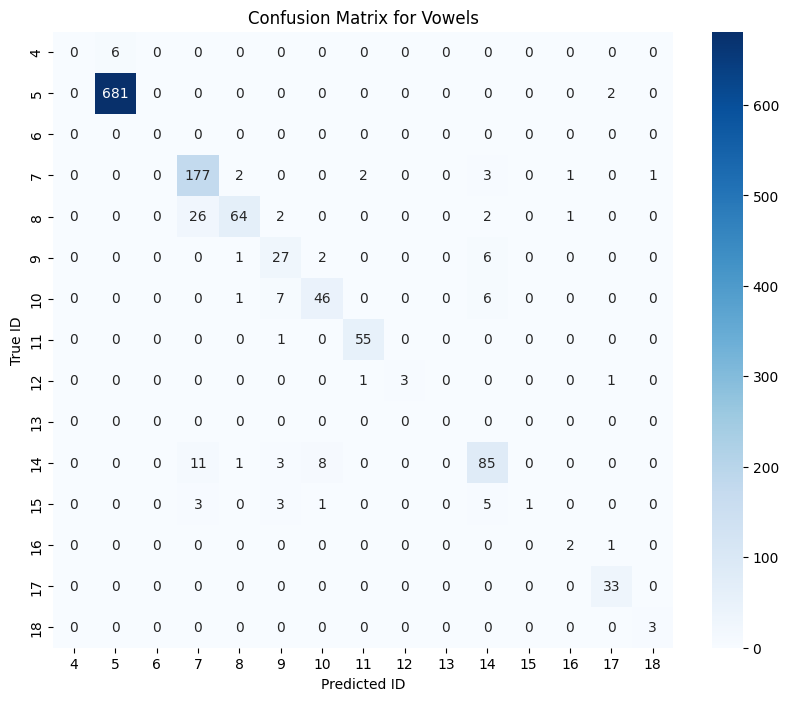

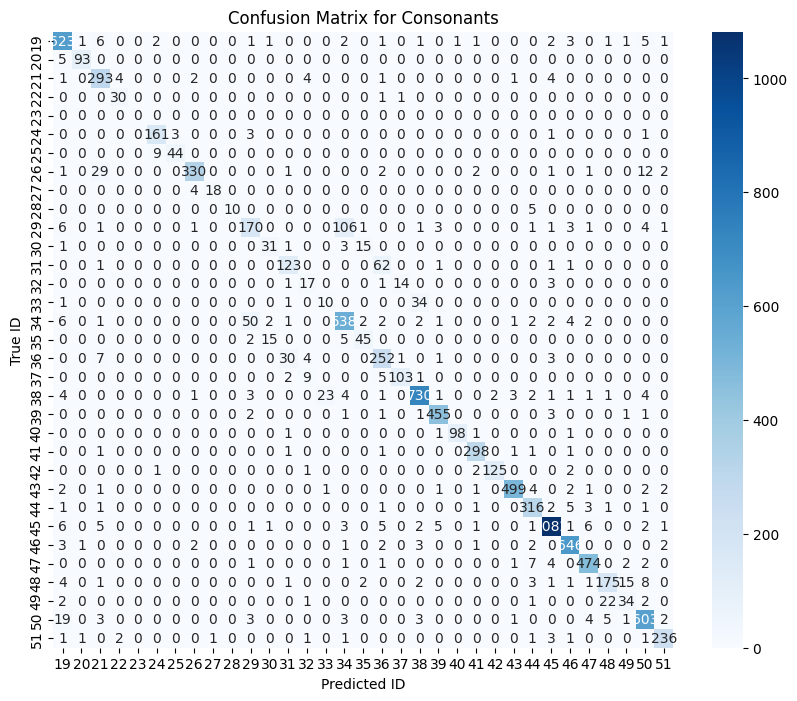

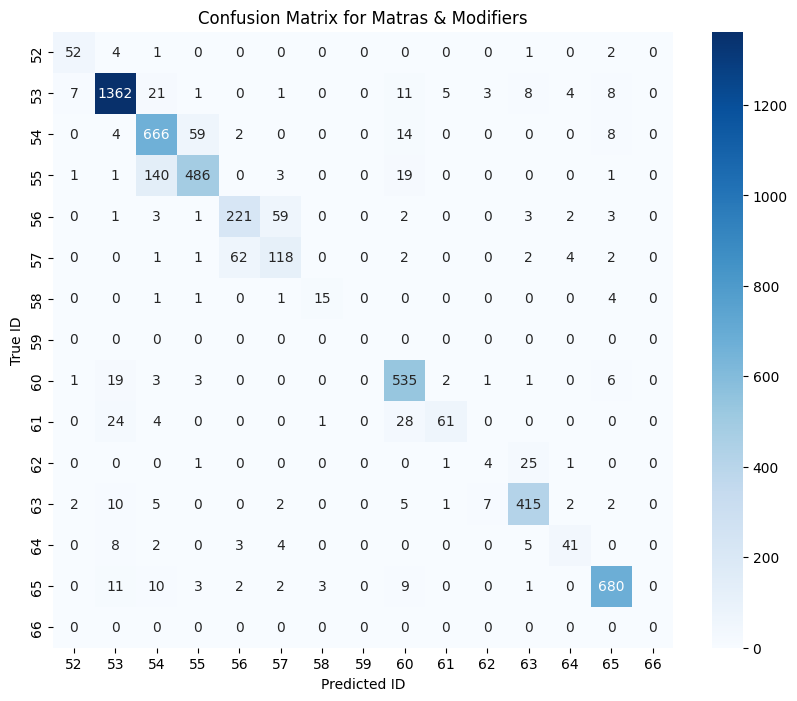

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your id groups (already defined)
special_token_ids = [0, 1, 2, 3]  
vowel_ids = list(range(4, 19))   
consonant_ids = list(range(19, 52))  
matra_ids = list(range(52, 67))  

groups = {
    "Special Tokens": special_token_ids,
    "Vowels": vowel_ids,
    "Consonants": consonant_ids,
    "Matras & Modifiers": matra_ids,
}

# Function to filter y_true and y_pred by group of predicted IDs
def filter_by_pred_group(y_true, y_pred, group_ids):
    filtered_true = []
    filtered_pred = []
    for yt, yp in zip(y_true, y_pred):
        if yp in group_ids:
            filtered_true.append(yt)
            filtered_pred.append(yp)
    return filtered_true, filtered_pred

# Plot confusion matrix heatmap function
def plot_cm(y_true_group, y_pred_group, group_ids, group_name):
    # Compute confusion matrix
    cm = confusion_matrix(
        y_true_group, 
        y_pred_group, 
        labels=group_ids
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=group_ids, yticklabels=group_ids)
    plt.title(f"Confusion Matrix for {group_name}")
    plt.xlabel("Predicted ID")
    plt.ylabel("True ID")
    plt.show()

# Loop over groups and plot
for group_name, group_ids in groups.items():
    y_true_group, y_pred_group = filter_by_pred_group(y_true, y_pred, group_ids)
    
    # If no data points for this group, skip plotting
    if len(y_true_group) == 0:
        print(f"No data to plot for group: {group_name}")
        continue
    
    plot_cm(y_true_group, y_pred_group, group_ids, group_name)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  f

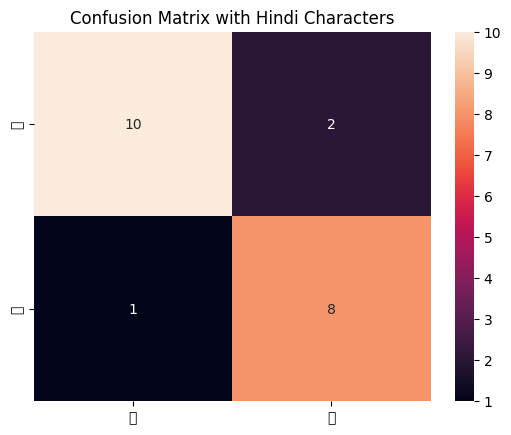

In [73]:
import os
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

# Create folder for fonts
font_dir = '/kaggle/working/fonts'
os.makedirs(font_dir, exist_ok=True)
font_path = os.path.join(font_dir, 'NotoSansDevanagari-Regular.ttf')

# Download and extract if not present
if not os.path.exists(font_path):
    url = "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansDevanagari-unhinted.zip"
    zip_path = os.path.join(font_dir, 'NotoSansDevanagari.zip')
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extract('NotoSansDevanagari-Regular.ttf', font_dir)
    os.remove(zip_path)

# Register font with matplotlib
prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

# Example data
conf_matrix = np.array([[10, 2], [1, 8]])
labels = ['अ', 'आ']

# Plot confusion matrix with Hindi characters
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with Hindi Characters')
plt.show()

No data to plot for group: Special Tokens


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages

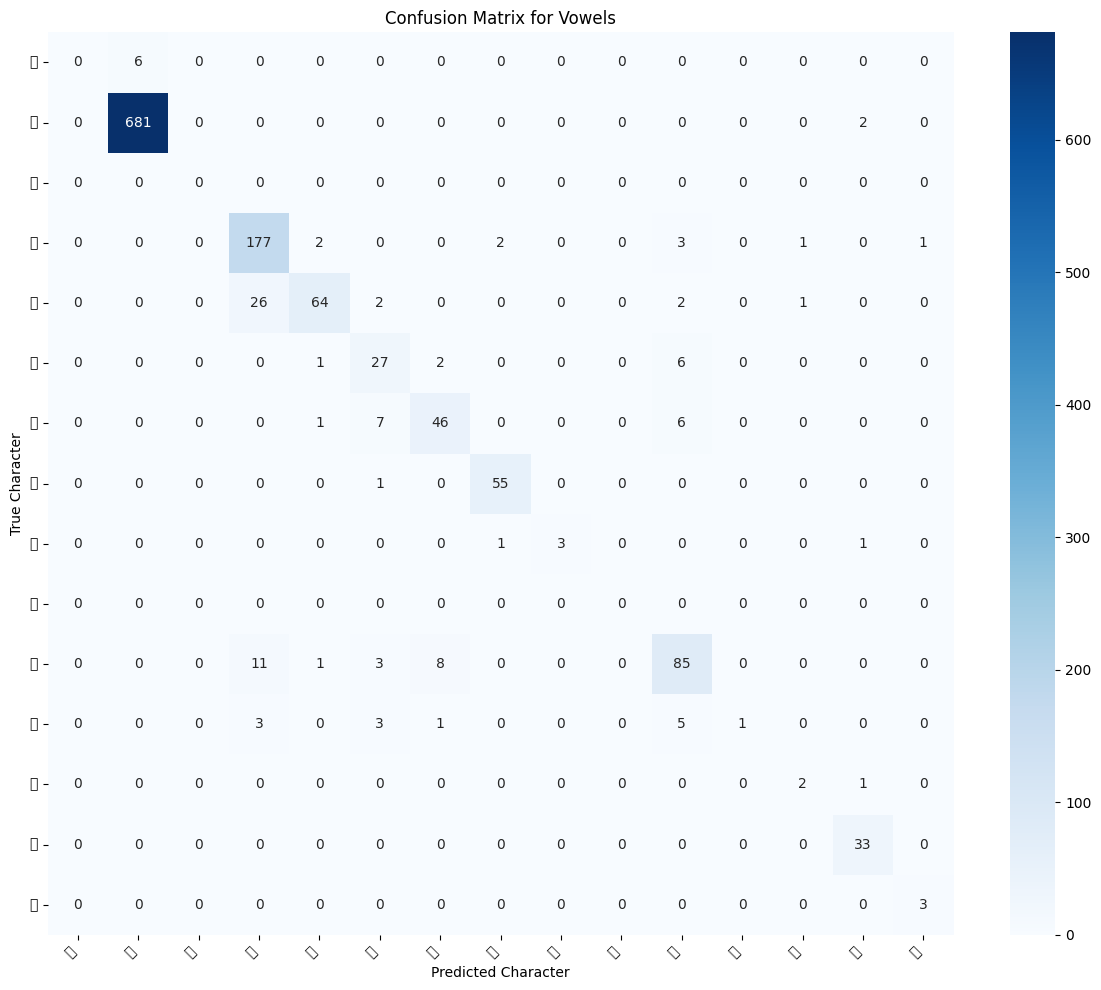

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2328 (\N{DEVANAGARI LETTER GHA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2329 (\N{DEVANAGARI LETTER NGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/u

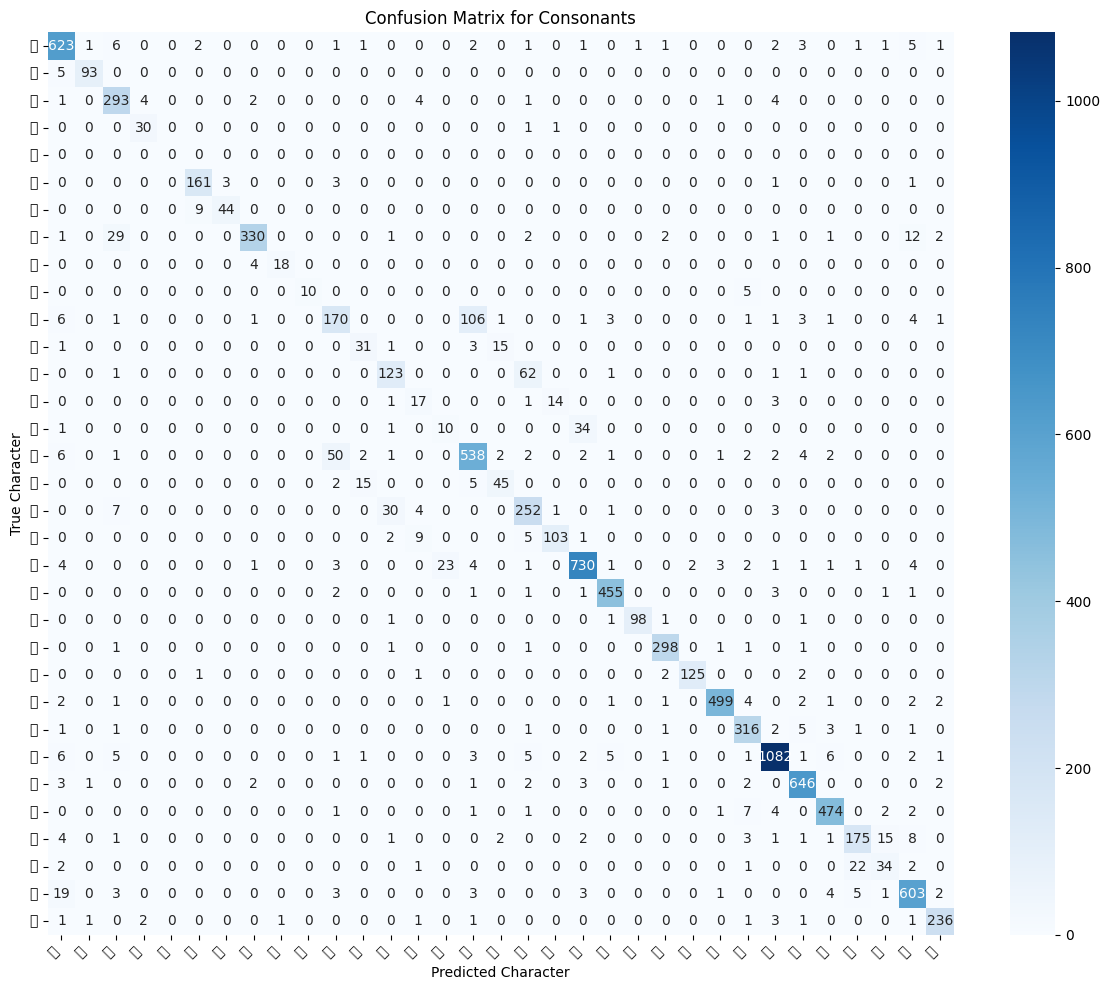

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packag

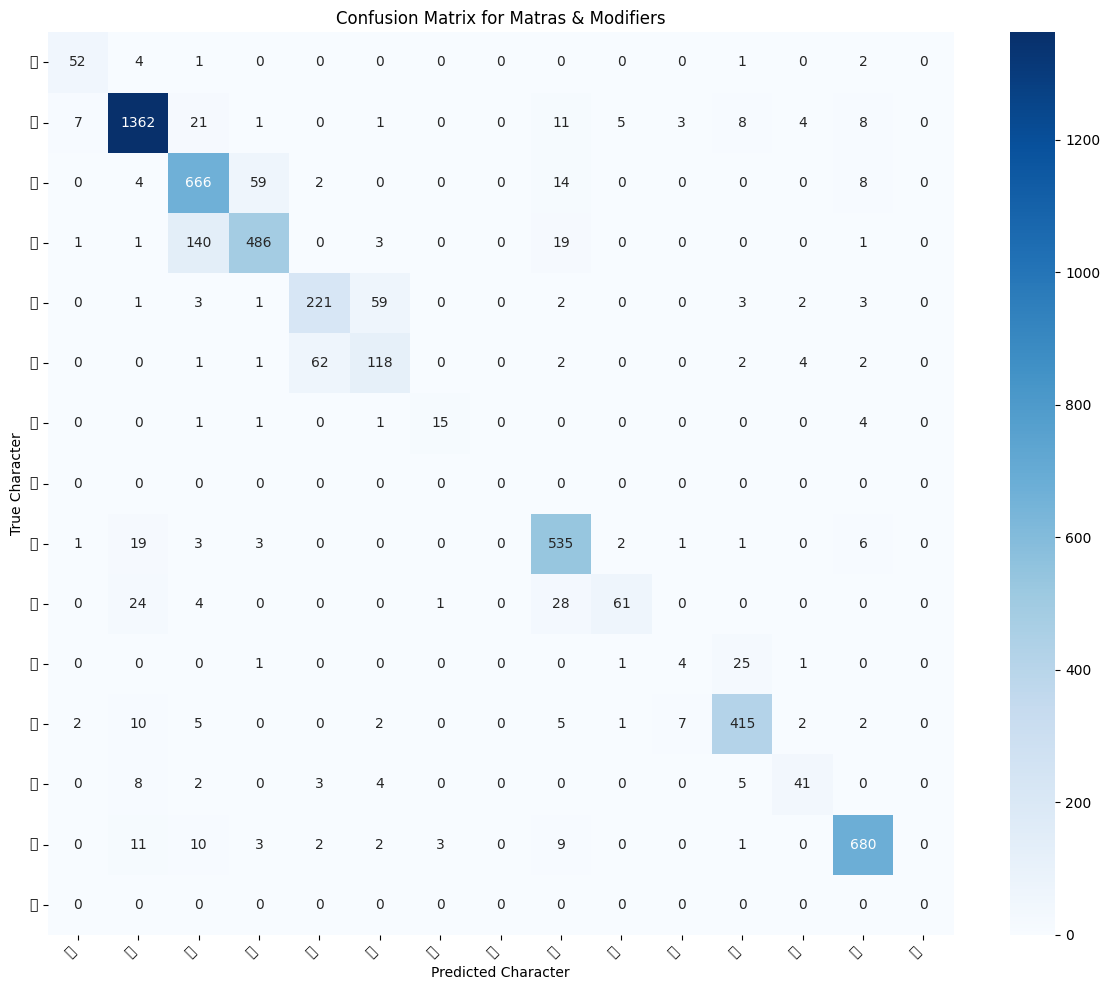

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your id groups (already defined)
special_token_ids = [0, 1, 2, 3]  
vowel_ids = list(range(4, 19))   
consonant_ids = list(range(19, 52))  
matra_ids = list(range(52, 67))  

groups = {
    "Special Tokens": special_token_ids,
    "Vowels": vowel_ids,
    "Consonants": consonant_ids,
    "Matras & Modifiers": matra_ids,
}

# Function to filter y_true and y_pred by group of predicted IDs
def filter_by_pred_group(y_true, y_pred, group_ids):
    filtered_true = []
    filtered_pred = []
    for yt, yp in zip(y_true, y_pred):
        if yp in group_ids:
            filtered_true.append(yt)
            filtered_pred.append(yp)
    return filtered_true, filtered_pred

# Plot confusion matrix heatmap function with characters
def plot_cm_chars(y_true_group, y_pred_group, group_ids, group_name, idx2char):
    # Compute confusion matrix
    cm = confusion_matrix(
        y_true_group, 
        y_pred_group, 
        labels=group_ids
    )
    
    # Map group ids to chars for labels
    char_labels = [idx2char[i] for i in group_ids]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=char_labels, yticklabels=char_labels)
    plt.title(f"Confusion Matrix for {group_name}")
    plt.xlabel("Predicted Character")
    plt.ylabel("True Character")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Run plotting for each group
for group_name, group_ids in groups.items():
    y_true_group, y_pred_group = filter_by_pred_group(y_true, y_pred, group_ids)
    
    if len(y_true_group) == 0:
        print(f"No data to plot for group: {group_name}")
        continue
    
    plot_cm_chars(y_true_group, y_pred_group, group_ids, group_name, output_idx2char)
